In [824]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px
import pickle
import time
import easygui


## Open Data and Join Data

In [791]:
print("Please choose the TEST file in the dialogue (should be a CSV file - see ReadMe)")
filename = easygui.fileopenbox()
data_train = pd.read_csv(filename)
data_store = pd.read_csv("data/store_AnSeb.csv")
dt = data_train.merge(data_store, left_on='Store', right_on='Store', how="left")

/Users/selbo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



/Users/selbo/DSR/minicomp-rossman/AnselSebastian1.py


## Clean Data

In [792]:
#Drop the Customers because we will not have it in the Future
dt = dt.drop("Customers", axis=1)

In [795]:
#Date Variable format
dt['Date'] = pd.DatetimeIndex(dt['Date']) 

## Get rid of missing Stores (they miss too many features)

In [738]:
#at this get rid of missing store
dt = dt.dropna( how='any', subset=["Store"])
#also change to INTEGER
dt.loc[:, "Store"] = dt.loc[:, "Store"].astype(int)

# Feature Engineering

In [ ]:
dt.Open.fillna(1, inplace=True)

#Make a variable ReOPENING that 1 one if a shop opens after 5 days of absence
dt['Open_5']  = dt.groupby('Store')['Open'].transform(lambda x: x.rolling(5,  min_periods=5).mean())
dt['Open_last5'] = dt.groupby('Store')['Open_5'].shift(1)

dt['Reopening'] = (dt.Open_last5 == 0) & (dt.Open == 1)

In [740]:
#make one-hot-encoding for the StateHoliday variable
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None
dt_eng = dt
dt_eng.loc[: , "PublicHoliday"] = dt.loc[:, "StateHoliday"]=="a" 
dt_eng.loc[: , "Easter"] = dt.loc[:, "StateHoliday"]=="b" 
dt_eng.loc[: , "Christmas"] = dt.loc[:, "StateHoliday"]=="c" 

In [741]:
#StoreType One-Hot encoding
dummies = pd.get_dummies(dt.loc[:, "StoreType"], prefix="storetype", prefix_sep='_')
dt_eng = pd.concat([dt_eng, dummies], axis=1)

In [744]:
#Assortment
dummies = pd.get_dummies(dt_eng.loc[:, "Assortment"], prefix="assort", prefix_sep='_')
dt_eng = pd.concat([dt_eng, dummies], axis=1)


In [755]:
dt_eng.loc[:, "logDistance"] = np.log(dt_eng.loc[:, "CompetitionDistance"])

## Drop the Sales = 0 (after feature engineering)

In [756]:
dt_eng = dt_eng.dropna( how='any', subset=['Sales'])
sales_zeros=(dt_eng["Sales"] == 0)
dt_eng = dt_eng.loc[~sales_zeros, :]

In [ ]:
#impute the School Holiday
dt_eng["SchoolHoliday"] = dt_eng["SchoolHoliday"].fillna(0)
dt_eng['CompetitionDistance'] = dt_eng['CompetitionDistance'].fillna(dt_eng['CompetitionDistance'].mean())
dt_eng['logDistance'] = dt_eng['logDistance'].fillna(dt_eng['logDistance'].mean())

### time series stuff

In [760]:
##Add Monthly Fixed Effects
dt_eng['day'] = pd.DatetimeIndex(dt_eng['Date']).day
dt_eng['month'] = pd.DatetimeIndex(dt_eng['Date']).month
dt_eng['week'] = pd.DatetimeIndex(dt_eng['Date']).week
dt_eng['year'] = pd.DatetimeIndex(dt_eng['Date']).year

<ipython-input-760-907aadee8390>:4: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



In [761]:
dummies = pd.get_dummies(dt_eng.loc[:, "month"], prefix="m", prefix_sep='_')
dt_eng = pd.concat([dt_eng, dummies], axis=1)

In [762]:
dt_eng = dt_eng.dropna( how='any', subset=["DayOfWeek"])
dummies = pd.get_dummies(dt_eng.loc[:, "DayOfWeek"].astype(int), prefix="dow", prefix_sep='_')
dt_eng = pd.concat([dt_eng, dummies], axis=1)

In [763]:
#Beginning of the month craze
dt_eng["monthstart"] = (dt_eng.day>=30) | ( dt_eng.day<=3)

In [764]:
dt_eng["prstart"] = (dt_eng.Promo2SinceWeek <= dt_eng.week) & (dt_eng.Promo2SinceYear <= dt_eng.year)
dt_eng = pd.concat([dt_eng, dt_eng["PromoInterval"].str.split(',', expand=True)], axis=1)

,Date,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,week,year,prstart
627808,2014-07-21,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",30,2014,True
628743,2014-07-22,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",30,2014,True
629678,2014-07-23,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",30,2014,True
630612,2014-07-24,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",30,2014,True
631548,2014-07-25,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",30,2014,True
632482,2014-07-26,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",30,2014,True
634352,2014-07-28,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",31,2014,True
635287,2014-07-29,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",31,2014,True
636222,2014-07-30,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",31,2014,True
637158,2014-07-31,1.0,10.0,2014.0,"Mar,Jun,Sept,Dec",31,2014,True


In [ ]:
def mnames(s):
    if s=="Jan":
        return 1
    if s=="Feb":
        return 2
    if s=="Mar":
        return 3
    if s=="Apr":
        return 4
    if s=="May":
        return 5
    if s=="Jun":
        return 6
    if s=="Jul":
        return 7
    if s=="Aug":
        return 8
    if s=="Sept":
        return 9
    if s=="Oct":
        return 10
    if s=="Nov":
        return 11
    if s=="Dec":
        return 12

In [ ]:
dt_eng.loc[:, 'pr1'] = dt_eng.loc[:, 0].apply(lambda row : mnames(row))
dt_eng.loc[:, 'pr2'] = dt_eng.loc[:, 1].apply(lambda row : mnames(row))
dt_eng.loc[:, 'pr3'] = dt_eng.loc[:, 2].apply(lambda row : mnames(row))
dt_eng.loc[:, 'pr4'] = dt_eng.loc[:, 3].apply(lambda row : mnames(row))

dt_eng.loc[:, "themonth"] = (dt_eng['pr1'] == dt_eng["month"])|(dt_eng['pr2'] == dt_eng["month"])|(dt_eng['pr4'] == dt_eng["month"])|(dt_eng['pr3'] == dt_eng["month"])  
dt_eng["pr_campaign"] = (dt_eng['prstart']==True) & (dt_eng["themonth"] == True)

In [765]:
#Make a Variable that counts the days since day 1
dt_eng['Date'] = pd.to_datetime(dt_eng['Date']) 
dt_eng['date_delta'] = (dt_eng['Date'] - dt_eng['Date'].min())  / np.timedelta64(1,'D')

In [766]:
#Define 'City_Center' =1 if distance <800 & competition open since year <2004
dt_eng['City_center'] = (dt_eng['CompetitionDistance'] < 500) &(dt_eng['CompetitionOpenSinceYear'] < 2004)

False    475220
True       7346
Name: City_center, dtype: int64

In [767]:
#checkoing the data, one can see that in uneven weeks the first 3 days are selling especially well, this is one way to make it
dt_eng['week1'] = ((dt_eng['week'] % 4) == 0) 
dt_eng['week3'] = ((dt_eng['week'] % 4) == 2)
dt_eng['week13'] = ((dt_eng['week'] % 4) == 0) | ((dt_eng['week'] % 4) == 2)
dt_eng['week13'].value_counts()
dt_eng['firstdaysweek13'] = ((dt_eng['week13']) == True) & (dt_eng['DayOfWeek'] < 4 )

In [768]:
#another way is to code the weekdays separately.... 
dt_eng["Fortnight_Days"] = dt_eng["DayOfWeek"]
dt_eng.Fortnight_Days.value_counts()
dt_eng.loc[dt_eng['week13']==True, "Fortnight_Days"] = dt_eng["Fortnight_Days"] * 2 
dt_eng.Fortnight_Days.value_counts()

4.0     81666
6.0     80508
2.0     80235
12.0    41272
3.0     41082
5.0     40302
10.0    39728
1.0     39261
8.0     36507
14.0     1003
7.0      1002
Name: Fortnight_Days, dtype: int64

In [ ]:
dic = {7: 1, 1: 2, 2:3, 3:4, 4:5, 5: 6 , 6: 7}
dt_eng['DayOfWeek_recode'] = dt_eng['DayOfWeek'].replace(dic)


## Final Feature selection

In [770]:

features = [ "Store", 'SchoolHoliday', 'logDistance', 'prstart', 'Promo2', 'PublicHoliday', 'Easter', 'Christmas' 
            , 'Sales_avg_store', 'storetype_a', 'storetype_b', 'storetype_c', 'storetype_d', 'assort_a', 'assort_b', 'assort_c',
            "monthstart", "date_delta", "City_center", "firstdaysweek13", 
           "m_12", "Fortnight_Days", "DayOfWeek_recode",
           "dow_1", "dow_5", "dow_6",  "dow_2", "dow_3", "dow_4","dow_7" , "pr_campaign", "Reopening"]

In [771]:
dt_eng_nomissing = dt_eng.dropna( how='any', subset=["StateHoliday", "Assortment"])
dt_eng_nomissing = dt_eng_nomissing.dropna( how='any', subset=features)

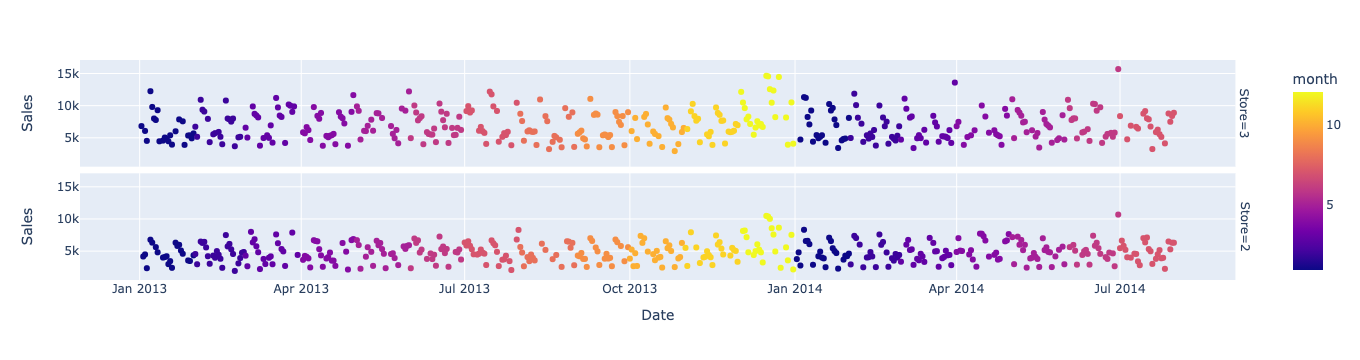

In [772]:

shop2 = (dt_eng_nomissing.loc[:, "Store"]==2) | (dt_eng_nomissing.loc[:, "Store"]==3) 
px.scatter(dt_eng_nomissing[shop2], x="Date", y="Sales",  facet_row='Store', color="month", hover_name="firstdaysweek13")


In [807]:
X = dt_eng_nomissing.loc[:, features ]
y = dt_eng_nomissing.loc[:, 'Sales']

## Modelling

### Baseline

In [800]:
def rmspe(preds, actuals):
    #preds = preds.reshape(-1)
    #actuals = actuals.reshape(-1)
    #assert preds.shape == actuals.shape
    return round(np.sqrt(np.mean(np.square((actuals-preds) / actuals))) * 100,4)

In [801]:
m1 = pickle.load(open("model_AnSeb.sav", 'rb'))

predictions = m1.predict(X)

print(f"Ansel and Sebastians model has an RMSPE of {rmspe(predictions, y)}")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.8s


Ansel and Sebastians model has an RMSPE of 8.8613


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    2.2s finished


In [820]:
#Baseline
#y.loc[:, "Baseline"] = 5
#dt.loc[:, "Sales"].mean()
#y.loc[:, "new_row"] = 5
y = pd.DataFrame(y)
y.loc[:, "Baseline"] = y.loc[:, "Sales"].mean()
baseline_rmspe = rmspe(y.loc[:, "Baseline"], y.loc[:, "Sales"])
print(f"The Baseline (average) RMSPE is just {baseline_rmspe}")
time.sleep(5)
print(f".....looks like Ansel and Seb rock")

The Baseline (average) RMSPE is just 61.6708
.....looks like Ansel and Seb rock
